# DT Plot: Finding the Optimal Discrimination Threshold in Classification Problems

The class for preparing data and building the dashboard is defined in the module `interactive_discrimination_threshold.py`.

In [1]:
import pandas as pd
from pandas import CategoricalDtype
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from yellowbrick.classifier.threshold import discrimination_threshold
import warnings

from interactive_discrimination_threshold import InteractiveDiscriminationThreshold

## Dataset and Model

In this section we build a pipeline with a random forest classifier and train it on the "default-of-credit-card-clients" dataset from [OpenML](https://www.openml.org/d/42477).

In [2]:
X, y = fetch_openml(data_id=42477, return_X_y=True, as_frame=True)

In [3]:
def transform_data(df: pd.DataFrame, target: pd.Series, frac: float = 0.07,
                   random_state: int = 42) -> pd.DataFrame:
    "Transform non-numeric columns into categorical type and clean data."
    column_map = {'x1': 'amount',
                  'x2': 'gender',
                  'x3': 'education',
                  'x4': 'marital_status',
                  'x5': 'age',
                  'x6': 'repay_sep_2005',
                  'x7': 'repay_aug_2005',
                  'x8': 'repay_jul_2005',
                  'x9': 'repay_jun_2005',
                  'x10': 'repay_may_2005',
                  'x11': 'repay_apr_2005',
                  'x12': 'amount_sep_2005',
                  'x13': 'amount_aug_2005',
                  'x14': 'amount_jul_2005',
                  'x15': 'amount_jun_2005',
                  'x16': 'amount_may_2005',
                  'x17': 'amount_apr_2005',
                  'x18': 'prev_amount_sep_2005',
                  'x19': 'prev_amount_aug_2005',
                  'x20': 'prev_amount_jul_2005',
                  'x21': 'prev_amount_jun_2005',
                  'x22': 'prev_amount_may_2005',
                  'x23': 'prev_amount_apr_2005'
                 }
    categories_map = {'gender': {1: 'male', 2: 'female'},
                      'education': {1: 'graduate', 2: 'university', 3: 'high_school',
                                    4: 'others', 5: 'others', 6: 'others', 0: 'others'},
                      'marital_status': {1: 'married', 2: 'single', 3: 'others', 0: 'others'}}
    df = df.copy()
    df['is_default'] = target.astype('int')
    df.rename(columns=column_map, inplace=True)
    for col_id, col_map in categories_map.items():
        df[col_id] = df[col_id].map(col_map).astype(CategoricalDtype(categories=list(set(col_map.values()))))
    df = df.groupby('is_default').sample(frac=0.2, random_state=random_state).reset_index(drop=True)
    return df.drop('is_default', axis=1), df['is_default'] 

X, y = transform_data(X, y)

Before feeding the data to the pipeline, we identify the categorical columns (which are expressed numerically in the original dataset) and explicitly transform their type to avoid any undesirable effects in later stages. Specifically, since the pipeline will be trained and tested multiple times on various subsamples of our dataset, we want to eliminate the cases when a categorical predictor in the test set receives a value not present in the training set. One way to deal with it is applying stratified random split, but our dataset contains several categorical columns. Another option is to explicitly transform non-numeric columns into pandas' `CategoricalDtype` with predefined ordered values, so that whenever some value for some column does not exist in the training set, receiving such a value in the test would not lead to incorrectly assigned labels or any other logical error. The function *transform_data()* below does exactly that.  However, we should note that to implement the second option, we have to know in advance all possible values for the categorical columns. Also, if the dataset is too large, we can optionally take a sample from the dataset in order to speed up the execution.   

Because we transformed the data with `CategoricalDtype`, after fitting the pipeline the function `OrdinalEncoder()` will know all the values that categorical variables in the test set can possibly take. 

In [5]:
encode_cat = ColumnTransformer(
  [('cat', OrdinalEncoder(), make_column_selector(dtype_include='category'))],
  remainder='passthrough'
)

model = Pipeline(steps=[
    ('encode_cat', encode_cat),
    ('rfc', RandomForestClassifier(n_estimators=50, oob_score=True))
])

## Existing Implementation

Most likely, there are several Python implementations of the DS plot, but we will use the one from [Yellowbrick](https://www.scikit-yb.org/en/latest/api/classifier/threshold.html) package. The plot below corresponds to the default case, when we perceive precision and recall as equally "important" (therefore, having equal weight).

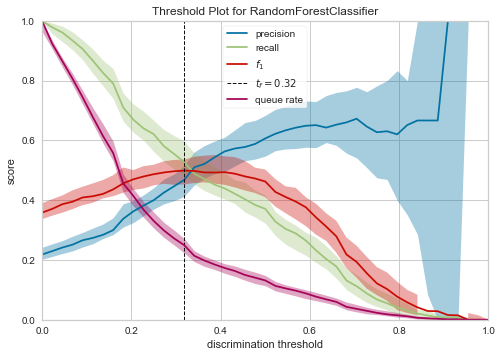

In [7]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    discrimination_threshold(model, X, y)

Alternatively, giving to recall (in our example, 1.5 times) larger weight than to precision will drive the optimal threshold down. We can manipulate the relative weights between precision and recall with `fbeta` argument. 

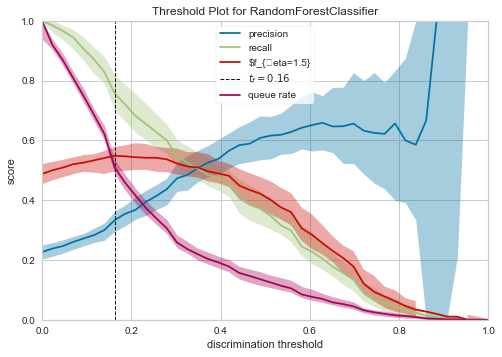

In [9]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    discrimination_threshold(model, X, y, fbeta=1.5)

## Our version

Yellowbrick's plot has two main drawbacks:

1) It is static, which makes it difficult to observe the values for precision, recall and the other performance metrics for any given threshold;

2) It is not interactive, i.e. doesn't have input widgets.
    
In contrast, the Plotly Dash implementation below is designed so that:

1) We can see the value of each performance metric by hovering mouse pointer to the area near that value;

2) We can manipulate the plot's main input parameters with widgets;

3) The dashboard has two modes: basic mode (mimics the behavior of Yellowbrick's implementation) and constrained mode. In the constrained mode instead of directly calculating the threshold we firstly create a payout function, which is calculated using three additional input parameters: (i) the reviewing capacity, i.e. what share of observations with positive predicted values we are capable to screen and see if they are true positives or not; (ii) cost of reviewing one observation; and (iii) estimated payoff from each true positive. Then we find the optimal discrimination threshold as the cutoff value which maximizes that payout function.

In [8]:
disc_threshold = InteractiveDiscriminationThreshold(model, X, y)
disc_threshold.prepare_data(store_data=True)

100%|███████████████████████████████████████████| 35/35 [00:16<00:00,  2.16it/s]


If we want to observe the plot within this notebook, we call the object's `plot()` with the parameter app_mode='inline' and if we want to see the plot in a separate window, we call it with app_mode='external'. For all other parameters, please see the docstring for the class or function in the modules `interactive_discrimination_threshold.py` and `app.py`.

In [ ]:
disc_threshold.input_df.index.is_unique

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    disc_threshold.plot(app_mode='external')